In [2]:
import os
print(os.getcwd())

/Users/ziyingfeng/Dropbox/data incubator


In [3]:
os.chdir('/Users/ziyingfeng/Dropbox/data incubator/project')

In [4]:
import numpy as np # for doing most of our calculations
import matplotlib.pyplot as plt# for plotting
from utils.data_utils import load_CIFAR10 # function to load the CIFAR-10 dataset.

# Load matplotlib images inline
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [5]:
# Set the path to the CIFAR-10 data
cifar10_dir = 'cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

In [6]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


## Vectorized KNN prediction

In [12]:
import numpy as np
import pdb


class KNN(object):

    def __init__(self):
        pass

    def train(self, X, y):
        """
        Inputs:
        - X is a numpy array of size (num_examples, D)
        - y is a numpy array of size (num_examples, )
        """
        self.X_train = X
        self.y_train = y

    def compute_distances(self, X, norm=None):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train.

        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data.
        - norm: the function with which the norm is taken.

        Returns:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          is the Euclidean distance between the ith test point and the jth training
          point.
        """
        if norm is None:
            norm = lambda x: np.sqrt(np.sum(x**2))
            #norm = 2

        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))
        for i in np.arange(num_test):

            for j in np.arange(num_train):

                dists[i,j] = norm(X[i] - self.X_train[j])

        return dists

    def compute_L2_distances_vectorized(self, X):
        """
        Compute the distance between each test point in X and each training point
        in self.X_train WITHOUT using any for loops.

        Inputs:
        - X: A numpy array of shape (num_test, D) containing test data.

        Returns:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          is the Euclidean distance between the ith test point and the jth training
          point.
        """
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        dists = np.zeros((num_test, num_train))


        #Intuitively: Distance = sqrt( (X - Y)^2) = sqrt((X^2 + Y^2 - 2XY))
        #square the train's and test's values  X^2, Y^2    
        X_2 = np.sum(X ** 2, axis = 1)
        train_2 = np.sum(self.X_train ** 2, axis = 1)

        #make the shapes compatatible
        X_2_repeat = np.array([X_2] * self.X_train.shape[0]).T
        train_2_repeat = np.array([train_2] * X.shape[0])

        #XY
        X_dot_train = X.dot(self.X_train.T)

        #(x^2 + y^2 - 2xy)
        dists = np.sqrt(X_2_repeat + train_2_repeat - 2 * X_dot_train)


        return dists


    def predict_labels(self, dists, k=1):
        """
        Given a matrix of distances between test points and training points,
        predict a label for each test point.

        Inputs:
        - dists: A numpy array of shape (num_test, num_train) where dists[i, j]
          gives the distance betwen the ith test point and the jth training point.

        Returns:
        - y: A numpy array of shape (num_test,) containing predicted labels for the
          test data, where y[i] is the predicted label for the test point X[i].  
        """
        num_test = dists.shape[0]
        y_pred = np.zeros(num_test)
        for i in np.arange(num_test):
          # A list of length k storing the labels of the k nearest neighbors to
          # the ith test point.
            closest_y = []

            dist_sort = np.argsort(dists[i])
            nearest_point_idx_in_Xtrain = dist_sort[:k]
            closest_y = self.y_train[nearest_point_idx_in_Xtrain]
            y_pred[i] = np.argmax(np.bincount(closest_y))

        return y_pred



In [18]:
# Declare an instance of the knn class.

knn = KNN()

# Train the classifier.

knn.train(X=X_train, y=y_train)

In [22]:
# Implement the function compute_L2_distances_vectorized() in the KNN class.
# In this function, you ought to achieve the same L2 distance but WITHOUT any for loops.
# Note, this is SPECIFIC for the L2 norm.

dists_L2_vectorized = knn.compute_L2_distances_vectorized(X=X_test)
print('Frobenius norm of L2 distances: {}'.format(np.linalg.norm(dists_L2_vectorized, 'fro')))

Frobenius norm of L2 distances: 7906696.077040902


In [23]:
# Implement the function predict_labels in the KNN class.
# Calculate the training error (num_incorrect / total_samples) 
# from running knn.predict_labels with k=1

error = 1

# ================================================================ #
#   Calculate the error rate by calling predict_labels on the test 
#   data with k = 1.  Store the error rate in the variable error.
# ================================================================ #
error = 1.0*np.sum((knn.predict_labels(dists = dists_L2_vectorized) - y_test) != 0) / y_test.shape[0]
y_pred = knn.predict_labels(dists = dists_L2_vectorized)

print(error)

0.726


This means that the k-nearest neighbors classifier is right 27.4% of the time, which is not great, considering that chance levels are 10%.

# Optimizing KNN hyperparameters

Take the KNN classifier that you have constructed and perform cross-validation to choose a best value of $k$.

### Create training and validation folds

create the training and validation folds for use in k-fold cross validation.

In [26]:
# Create the dataset folds for cross-valdiation.
num_folds = 5

X_train_folds = []
y_train_folds =  []

# ================================================================ #
#   Split the training data into num_folds (i.e., 5) folds.
#   X_train_folds is a list, where X_train_folds[i] contains the 
#   data points in fold i.
#   y_train_folds is also a list, where y_train_folds[i] contains
#   the corresponding labels for the data in X_train_folds[i]
# ================================================================ #

X_test_fold = []
y_test_fold = []

num_train = X_train.shape[0]
cv_idx = np.arange(num_train)
np.random.shuffle(cv_idx)
fold_size = num_train // num_folds
for i in np.arange(num_folds):
    test_idx = cv_idx[i*fold_size : (i+1)*fold_size]
    train_idx = np.concatenate((cv_idx[:i*fold_size], cv_idx[(i+1)*fold_size:]))
    X_train_folds.append(X_train[train_idx])
    y_train_folds.append(y_train[train_idx])
    X_test_fold.append(X_train[test_idx])
    y_test_fold.append(y_train[test_idx])


len(X_train_folds)
X_test_fold[1].shape[0]

1000

### Optimizing the number of nearest neighbors hyperparameter.

select different numbers of nearest neighbors and assess which one has the lowest k-fold cross validation error.

Text(0, 0.5, 'error')

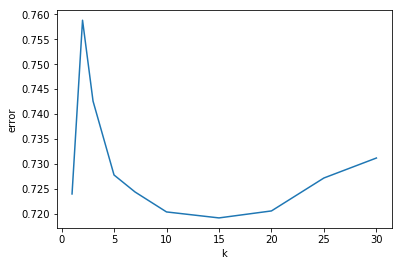

In [29]:
ks = [1, 2, 3, 5, 7, 10, 15, 20, 25, 30]

# ================================================================ #
#   Calculate the cross-validation error for each k in ks, testing
#   the trained model on each of the 5 folds.  Average these errors
#   together and make a plot of k vs. cross-validation error. Since 
#   we are assuming L2 distance here, please use the vectorized code!
#   Otherwise, you might be waiting a long time.
# ================================================================ #
train_error, val_error = (np.zeros(len(ks)), np.zeros(len(ks)))
k_idx = 0
for k in ks:    
    for i in np.arange(num_folds):
        knn.train(X=X_train_folds[i], y=y_train_folds[i])
        dists_L2_vectorized = knn.compute_L2_distances_vectorized(X = X_test_fold[i])
        y_pred = knn.predict_labels(dists = dists_L2_vectorized, k = k)
        val_error[k_idx] += np.sum((y_pred - y_test_fold[i]) != 0) / y_test_fold[i].shape[0]        
    val_error[k_idx] = 1.0*val_error[k_idx]/num_folds
    k_idx += 1
        
plt.plot(ks, val_error)
plt.xlabel('k')
plt.ylabel('error')


In [32]:
ks[np.argmin(val_error)]

15

value of 15 is best amongst the tested $k$'s

### Optimizing the norm

test three different norms (the 1, 2, and infinity norms) and see which distance metric results in the best cross-validation performance.

Text(0, 0.5, 'error')

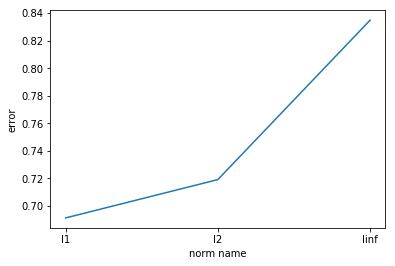

In [36]:

L1_norm = lambda x: np.linalg.norm(x, ord=1)
L2_norm = lambda x: np.linalg.norm(x, ord=2)
Linf_norm = lambda x: np.linalg.norm(x, ord= np.inf)
norms = [L1_norm, L2_norm, Linf_norm]

# ================================================================ #
#   Calculate the cross-validation error for each norm in norms, testing
#   the trained model on each of the 5 folds.  Average these errors
#   together and make a plot of the norm used vs the cross-validation error
#   Use the best cross-validation k from the previous part.  
#
#   Feel free to use the compute_distances function.  We're testing just
#   three norms, but be advised that this could still take some time.
#   You're welcome to write a vectorized form of the L1- and Linf- norms
#   to speed this up, but it is not necessary.
# ================================================================ #


train_error, val_error = (np.zeros(len(norms)), np.zeros(len(norms)))
k_idx = 0
for norm in norms:    
    for i in np.arange(num_folds):
        knn.train(X=X_train_folds[i], y=y_train_folds[i])
        dists = knn.compute_distances(X_test_fold[i], norm)
        y_pred = knn.predict_labels(dists, k=15)
        val_error[k_idx] += np.sum((y_pred - y_test_fold[i]) != 0) / y_test_fold[i].shape[0]        
    val_error[k_idx] = 1.0*val_error[k_idx]/num_folds
    k_idx += 1
        
plt.plot(['l1','l2','linf'], val_error)
plt.xlabel('norm name')
plt.ylabel('error')
